# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

<a id="Этап_1"></a>
<a id="1.1"></a>

### Этап 1: Загрузим и изучим данные 
#### Подключение библиотек

[Вернуться к задачам исследования](#Задачи_исследования)

In [1]:
import pandas as pd                                            # Библиотека для работы с данными, предоставляет функции и структуры данных, такие как DataFrame и Series.
import numpy as np                                             # Фундаментальная библиотека для научных вычислений с поддержкой многомерных массивов и матриц.
import warnings                                                # Модуль для управления предупреждениями.
import random                                                  # Импорт модуля для генерации случайных чисел

import statsmodels.api as sm                                                # statsmodels.api используется для оценки статистических моделей
from statsmodels.stats.outliers_influence import variance_inflation_factor  # variance_inflation_factor из statsmodels используется для определения мультиколлинеарности

# Модули для работы с машинным обучением
from sklearn.model_selection import train_test_split           # Инструмент библиотеки sklearn для разделения исходных данных на обучающую, валидационную и тестовую выборку.

# Модели машинного обучения
from sklearn.linear_model import LinearRegression

# Инструменты для оценки моделей и метрики
from sklearn.model_selection import learning_curve             # Инструмент для построения кривых обучения.
from sklearn.model_selection import GridSearchCV               # Инструмент для выполнения поиска по сетке параметров модели.
from sklearn.metrics         import accuracy_score             # Метрика - точность классификации.
from sklearn.metrics         import confusion_matrix           # Метрика - матрица неточностей.
from sklearn.metrics         import roc_curve, roc_auc_score   # Метрики - ROC-кривая и ROC AUC Score.
from sklearn.metrics         import f1_score                   # Метрика - F1 Score.
from sklearn.preprocessing   import StandardScaler             # Инструмент для маштабирования данны.


%pip install seaborn
# Визуализация данных
import matplotlib.pyplot as plt                                # Библиотека для визуализации данных.
import seaborn as sns                                          # Библиотека для красивой визуализации статистических данных.

# Настрйоки отображения
# Устанавливаем формат отображения чисел с двумя знаками после запятой 
pd.options.display.float_format = '{:.2f}'.format

# Устанавливает фильтр предупреждений
warnings.filterwarnings("ignore")

random_state = random.seed(42)

Note: you may need to restart the kernel to use updated packages.


In [2]:
try:
    df_geo_0 = pd.read_csv('/Users/Edward/Code/DS+/csv/geo_data_0.csv', sep = ',')
    df_geo_1 = pd.read_csv('/Users/Edward/Code/DS+/csv/geo_data_1.csv', sep = ',')
    df_geo_2 = pd.read_csv('/Users/Edward/Code/DS+/csv/geo_data_2.csv', sep = ',')
except:
    df_geo_0 = pd.read_csv('/datasets/geo_data_0.csv', sep = ',')
    df_geo_1 = pd.read_csv('/datasets/geo_data_1.csv', sep = ',')
    df_geo_2 = pd.read_csv('/datasets/geo_data_2.csv', sep = ',')

In [3]:
print(df_geo_0.info())
print('-' * 35)
print(df_geo_0.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
-----------------------------------
      id    f0    f1   f2  product
0  txEyH  0.71 -0.50 1.22   105.28
1  2acmU  1.33 -0.34 4.37    73.04
2  409Wp  1.02  0.15 1.42    85.27
3  iJLyR -0.03  0.14 2.98   168.62
4  Xdl7t  1.99  0.16 4.75   154.04


In [4]:
print(df_geo_1.info())
print('-' * 35)
print(df_geo_1.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
-----------------------------------
      id     f0     f1    f2  product
0  kBEdx -15.00  -8.28 -0.01     3.18
1  62mP7  14.27  -3.48  1.00    26.95
2  vyE1P   6.26  -5.95  5.00   134.77
3  KcrkZ -13.08 -11.51  5.00   137.95
4  AHL4O  12.70  -8.15  5.00   134.77


In [5]:
print(df_geo_2.info())
print('-' * 35)
print(df_geo_2.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
-----------------------------------
      id    f0    f1    f2  product
0  fwXo0 -1.15  0.96 -0.83    27.76
1  WJtFt  0.26  0.27 -2.53    56.07
2  ovLUW  0.19  0.29 -5.59    62.87
3  q6cA6  2.24 -0.55  0.93   114.57
4  WPMUX -0.52  1.72  5.90   149.60


In [6]:
print('Колличество дубликатов в df_geo_0:', df_geo_0.duplicated().sum())
print('Колличество дубликатов в df_geo_1:', df_geo_1.duplicated().sum())
print('Колличество дубликатов в df_geo_2:', df_geo_2.duplicated().sum())

Колличество дубликатов в df_geo_0: 0
Колличество дубликатов в df_geo_1: 0
Колличество дубликатов в df_geo_2: 0


In [7]:
print('Колличество пропущенных значений в df_geo_0:')
print(df_geo_0.isnull().sum())
print('-' * 15)
print('Колличество пропущенных значений в df_geo_1:')
print(df_geo_1.isnull().sum())
print('-' * 15)
print('Колличество пропущенных значений в df_geo_2:')
print(df_geo_2.isnull().sum())
print('-' * 15)

Колличество пропущенных значений в df_geo_0:
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
---------------
Колличество пропущенных значений в df_geo_1:
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
---------------
Колличество пропущенных значений в df_geo_2:
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
---------------


In [8]:
# Список всех DataFrame, которые нужно объединить
dataframes = [df_geo_0, df_geo_1, df_geo_2]

# Используем функцию concat для объединения DataFrame
df = pd.concat(dataframes, ignore_index=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       300000 non-null  object 
 1   f0       300000 non-null  float64
 2   f1       300000 non-null  float64
 3   f2       300000 non-null  float64
 4   product  300000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 11.4+ MB


In [10]:
df.head()

,id,f0,f1,f2,product
0,txEyH,0.71,-0.50,1.22,105.28
1,2acmU,1.33,-0.34,4.37,73.04
2,409Wp,1.02,0.15,1.42,85.27
3,iJLyR,-0.03,0.14,2.98,168.62
4,Xdl7t,1.99,0.16,4.75,154.04


In [11]:
df.describe()

,f0,f1,f2,product
count,300000.00,300000.00,300000.00,300000.00
mean,0.55,-1.52,2.50,85.44
std,5.32,3.90,2.92,46.52
min,-31.61,-26.36,-12.09,0.00
25%,-1.00,-2.48,0.65,52.67
50%,0.35,-0.23,2.49,84.04
75%,1.76,0.68,4.34,124.17
max,29.42,18.73,16.74,190.03


<a id="1.7"></a>

#### Исследуем Мультиколлинеарность 

Мультиколлинеарность - это явление, при котором два или более признака взаимно связаны друг с другом, что может вызвать проблемы при построении модели. Два основных типа проблем, связанных с мультиколлинеарностью:

- Затруднение интерпретации коэффициентов: Когда мультиколлинеарность присутствует, сложно определить точный вклад каждого признака в предсказание, так как их эффекты смешиваются между собой;

- Неустойчивость коэффициентов: Малейшие изменения в данных могут привести к значительным изменениям коэффициентов модели, что делает результаты менее надежными и устойчивыми;

- Мультиколлинеарность может быть особенно проблематичной для некоторых моделей, таких как линейная регрессия, логистическая регрессия и некоторые другие алгоритмы, которые используют линейную комбинацию признаков.

[Вернуться к задачам исследования](#Задачи_исследования)

In [12]:
# Выделяем независимые переменные (признаки)
X = df.drop(columns=['id', 'product'])

# Добавляем константу для использования модуля statsmodels
X_with_const = sm.add_constant(X)

# Создаем объект регрессии
model = sm.OLS(df['product'], X_with_const)

# Обучяем модель
result = model.fit()

# Рассчитываем VIF для каждого признака
vif = pd.DataFrame()
vif['Feature'] = X_with_const.columns
vif['VIF'] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

# Выводим результаты
print(vif)

  Feature  VIF
0   const 1.90
1      f0 1.01
2      f1 1.01
3      f2 1.00


Все значения VIF близки к 1, можно сделать вывод, что между переменными нет мультиколлинеарности.

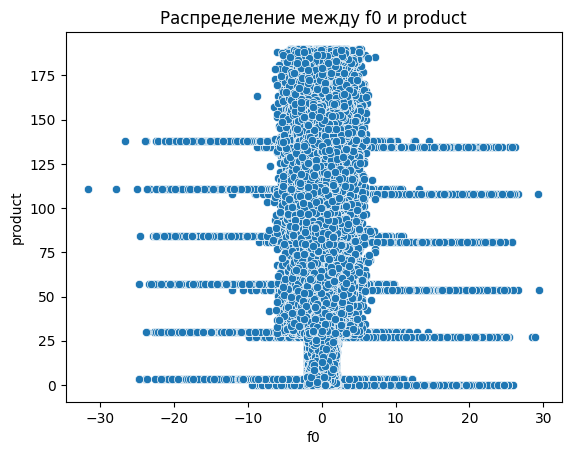

Коэффициент корреляции Пирсона между f0 и product: -0.03


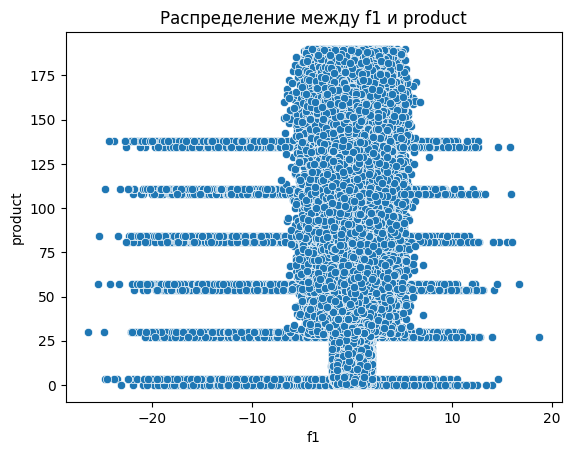

Коэффициент корреляции Пирсона между f1 и product: 0.14


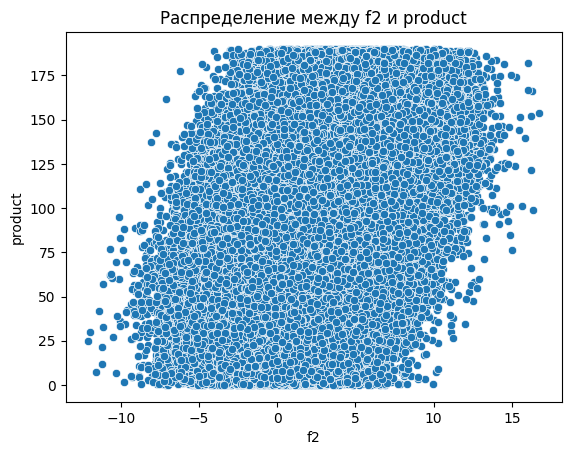

Коэффициент корреляции Пирсона между f2 и product: 0.53


In [13]:
from scipy.stats import pearsonr

# Визуализация линейного распределения между product и каждым из признаков
for column in ['f0', 'f1', 'f2']:
    sns.scatterplot(x=df[column], y=df['product'])
    plt.title(f'Распределение между {column} и product')
    plt.show()
    
    # Вычисление коэффициента корреляции Пирсона
    corr, _ = pearsonr(df[column], df['product'])
    print(f'Коэффициент корреляции Пирсона между {column} и product: {corr:.2f}')


#### Вывод:

- Данные чистые;

- Данные имеют широкий разброс, что не хорошо для моделей линейной регресии;

- Адекватная линейная зависимость наблюдается только между product и f2.

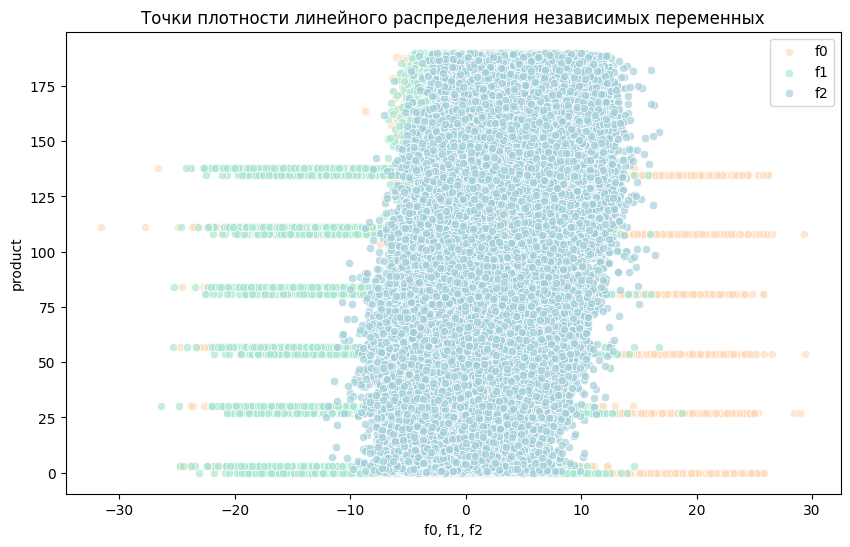

Общий коэффициент корреляции Пирсона для всех данных: 0.26


In [24]:
# Построение scatter plot с точками плотности для независимых переменных с различными цветами
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='f0', y='product', color='#FFDAB9AA', label='f0')
sns.scatterplot(data=df, x='f1', y='product', color='#A8E6CFAA', label='f1')
sns.scatterplot(data=df, x='f2', y='product', color='#A0CED9AA', label='f2')
plt.title('Точки плотности линейного распределения независимых переменных')
plt.xlabel('f0, f1, f2')
plt.ylabel('product')
plt.legend()
plt.show()

# Вычисление коэффициента корреляции Пирсона между зависимой переменной и объединенными независимыми переменными
combined_independent = df[['f0', 'f1', 'f2']].mean(axis=1)  # Среднее значение по всем независимым переменным
corr, _ = pearsonr(combined_independent, df['product'])
print(f'Общий коэффициент корреляции Пирсона для всех данных: {corr:.2f}')

Данные очень неусточевы к линейной зависимости.

Наши данные имеют разные масштабы, поэтому стандартизация или нормализация данных будет полезной.

- Стандартизация обычно подразумевает вычитание среднего значения и деление на стандартное отклонение для каждого признака. Это делает данные центрированными около 0 и имеющими стандартное отклонение 1;

- Нормализация обычно подразумевает масштабирование признаков в диапазоне от 0 до 1.

Предварительная обработка данных с помощью нормализации или стандартизации важна для линейной регрессии по следующим причинам:

- Скорость сходимости: Градиентный спуск, часто используемый для оптимизации в линейной регрессии, сходится быстрее, когда признаки имеют схожий масштаб. Это потому, что градиенты по разным параметрам будут иметь схожую величину;

- Устойчивость численных методов: Многие алгоритмы оптимизации чувствительны к масштабу данных. Стандартизация или нормализация данных помогает избежать численных проблем, связанных с неустойчивостью или затуханием градиентов;

- Интерпретация коэффициентов: Стандартизированные или нормализованные данные облегчают интерпретацию коэффициентов модели. Когда все признаки имеют одинаковый масштаб, коэффициенты можно интерпретировать как важность каждого признака для прогнозируемой переменной;

- Регуляризация: Если мы используем регуляризацию (например, L1 или L2), то важно масштабировать данные, потому что регуляризация штрафует абсолютные значения коэффициентов. Если один признак имеет масштаб, значительно отличающийся от других, его коэффициент будет непропорционально штрафоваться.

#### Подготовим данные к обучению

In [15]:
# X используем для обозначения признаков (features)
# y используем для обозначения целевой переменной (target)
X_features = df.drop(['id', 'product'], axis = 1)
y_target = df['product']

# Стандартизируем наши данные
# создание объекта StandardScaler
scaler = StandardScaler()

# обучение и преобразование данных
X_features = pd.DataFrame(scaler.fit_transform(X_features), columns=X_features.columns)

# Разделение данных на обучающую (75%) и временную (25%) выборки
X_train, X_val, y_train, y_val = train_test_split(X_features, y_target, test_size=0.25, random_state=random_state)

#### Вывод:

Анализ показал, что данные находятся в хорошем состоянии и подготовлены для проведения обучения.

#### Коэффициент Пирсона

Коэффициент корреляции Пирсона — это статистическая мера силы и направления линейной связи между двумя переменными. Коэффициент корреляции может принимать значения от -1 до +1. Значение +1 означает совершенную положительную линейную связь, значение -1 означает совершенную отрицательную линейную связь, а 0 означает отсутствие линейной связи.

Коэффициент корреляции Пирсона рассчитывается по формуле:

- $ r = \frac{n(\sum x_i y_i) - (\sum x_i)(\sum y_i)}{\sqrt{[n\sum x_i^2 - (\sum x)^2][n\sum y_i^2 - (\sum y_i)^2]}} $

где:

- $x$ и $y$ — значения переменных;

- $n$ — количество наблюдений.

Числитель:

- $ n(\sum x_i y_i) - (\sum x_i)(\sum y_i)$

Эта часть формулы представляет "ковариацию" между $x_i$ и $y_i$. Ковариация показывает, насколько переменные изменяются вместе. Если $x_i$ возрастает, когда $y_i$ возрастает, то ковариация будет положительной. Если $x_i$ уменьшается, когда $y_i$ возрастает, ковариация будет отрицательной. Если переменные не имеют явной связи, ковариация будет близка к нулю.

Знаменатель:

- $\sqrt{[n\sum x_i^2 - (\sum x)^2][n\sum y_i^2 - (\sum y_i)^2]}$

Эта часть формулы представляет собой произведение стандартных отклонений $x_i$ и $y_i$. Стандартное отклонение - это мера разброса значений переменной вокруг ее среднего значения. Знаменатель нормализует ковариацию, делая коэффициент корреляции Пирсона масштабно-инвариантным, т.е. он не зависит от масштаба измерения переменных.

Итоговый коэффициент корреляции:

Таким образом, коэффициент корреляции Пирсона представляет собой нормализованную ковариацию между двумя переменными. Это дает нам меру силы и направления линейной связи между переменными.

В контексте линейной регрессии коэффициент Пирсона может быть использован для оценки степени линейной зависимости между независимыми и зависимой переменными. Это может помочь в определении того, насколько переменные подходят для использования в модели линейной регрессии.

#### Линейная регрессия

Линейная регрессия — это статистический метод, используемый для моделирования и анализа взаимосвязей между переменными, где одна или несколько независимых переменных используются для прогнозирования значения зависимой переменной.

Модель линейной регрессии предполагает линейную зависимость между независимыми и зависимыми переменными, и она строится по следующей формуле:

- $ Y=β_0 + β_1 X_1 + β_2 X_2 +…+ β_n X_n + ϵ $

где:

- $Y$ — зависимая переменная, значение которой мы хотим предсказать;

- $X_1, X_2 ,…, X_n$ — независимые переменные, которые используются для предсказания значения Y;

- $β_0$ — это константа, которая представляет собой точку пересечения линии регрессии с осью Y, когда все независимые переменные равны нулю;

- $β_1, β_2 ,…, β_n$ — это коэффициенты регрессии, которые представляют изменение зависимой переменной $Y$ на единицу, при изменении соответствующей независимой переменной $X$, при условии, что все остальные независимые переменные остаются неизменными;

- $ϵ$ — это ошибка, которая представляет разницу между фактическим значением зависимой переменной и значением, предсказанным моделью линейной регрессии.

#### Оценка параметров

Для оценки параметров $β_0, β_1 ,…, β_n$ обычно используется метод наименьших квадратов (OLS). Этот метод минимизирует сумму квадратов ошибок (SSE), которые представляют собой разницу между фактическими и предсказанными значениями зависимой переменной.

- $ [ SSE = \sum_{i=1}^{n} (Y_i - \hat{Y}_i)^2] $

где:

- $Y_i$ — фактическое значение зависимой переменной для $i$-го наблюдения;

- $\hat{Y}_i$— значение зависимой переменной, предсказанное моделью линейной регрессии для $i$-го наблюдения.

#### Подбор значений наименьших квадратов

Метод наименьших квадратов (OLS) минимизирует сумму квадратов ошибок (SSE), находя значения параметров $β_0, β_1, …, β_n$, которые минимизируют SSE. Для этого, необходимо взять производные SSE по каждому параметру, приравнять их к нулю и решить полученные уравнения. Это приведет к аналитическому решению, описанному ниже.

#### Аналитическое решение

Линейная регрессия может быть представлена через аналитическое решение. Аналитическое решение можно получить, минимизируя сумму квадратов ошибок (SSE), что приводит к системе линейных уравнений, известной как уравнения нормального состояния. Для простой линейной регрессии с одной независимой переменной аналитическое решение может быть найдено из следующих формул:

- $ β_1 = \frac{n(\sum xy) - (\sum x)(\sum y)}{n\sum x^2 - (\sum x)^2} $

- $ β_0 = \frac{\sum y - β_1\sum x}{n} $

#### Предпосылки линейной регрессии

Для того чтобы модель линейной регрессии была действительной, должны выполняться следующие предпосылки:

- Линейность: Зависимость между зависимой и независимыми переменными должна быть линейной;

- Нормальность ошибок: Ошибки должны быть нормально распределены;

- Гомоскедастичность ошибок: Дисперсия ошибок должна быть одинаковой для всех значений независимых переменных;

- Независимость ошибок: Ошибки должны быть независимыми друг от друга;

- Отсутствие мультиколлинеарности: Независимые переменные не должны быть сильно коррелированными друг с другом.

#### Почему не стоит использовать интерполиационный полином Лагранжа

Интерполиационный полином Лагранжа используется для нахождения полинома, который проходит через заданный набор точек. Однако, этот метод не подходит для задач линейной регрессии по нескольким причинам:

- Переобучение: Интерполиационный полином Лагранжа будет проходить точно через каждую точку данных, что может привести к переобучению модели. Модель будет идеально описывать обучающий набор данных, но может плохо работать на новых данных;

- Высокая степень полинома: Интерполиационный полином Лагранжа может иметь высокую степень, что делает его сложным и неустойчивым. Например, если у нас есть 10 точек данных, интерполиационный полином будет 9-й степени;

- Вычислительная сложность: Расчет коэффициентов интерполиационного полинома Лагранжа может быть вычислительно сложным для больших наборов данных.

Из-за этих причин, интерполиационный полином Лагранжа не рекомендуется для задач линейной регрессии. Вместо этого, лучше использовать метод наименьших квадратов для нахождения параметров линейной регрессии.

#### Создаем дефолтную модель линейной регрессии

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# создание объекта линейной регрессии
model = LinearRegression()

# обучение модели
model.fit(X_train, y_train)

# предсказание на валидационных данных
y_pred = model.predict(X_val)

# оценка модели
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)

mse, rmse

(1492.4204053383687, 38.631857389185534)

#### Выполним преобразование данных, чтобы сделать их более "нормальными" в статистическом смысле, после чего обучим модель линейной регрессии на этих данных.

PowerTransformer из библиотеки scikit-learn выполняет степенное преобразование данных, чтобы сделать их более "нормальными" в статистическом смысле. Это означает, что после преобразования распределение данных стремится к нормальному (гауссовому) распределению.

Два наиболее распространенных метода степенного преобразования, встроенных в PowerTransformer, это:

- Преобразование Йео-Джонсона (Yeo-Johnson): это преобразование может быть применено к данным, которые могут принимать как положительные, так и отрицательные значения;

- Преобразование Бокса-Кокса (Box-Cox): это преобразование может быть применено только к данным, которые принимают положительные значения.

Основная идея обоих преобразований заключается в поиске оптимального параметра $λ$ таким образом, чтобы минимизировать отклонение распределения преобразованных данных от нормального распределения.

Формула преобразования Йео-Джонсона:

- $
y' = 
\begin{cases} 
\frac{y^\lambda - 1}{\lambda} & \text{если } \lambda \neq 0 \text{ и } y \geq 0 \\
\ln(y + 1) & \text{если } \lambda = 0 \text{ и } y \geq 0 \\
-\frac{(-y)^\lambda - 1}{\lambda} & \text{если } \lambda \neq 0 \text{ и } y < 0 \\
-\ln(-y + 1) & \text{если } \lambda = 0 \text{ и } y < 0
\end{cases} $

Формула преобразования Бокса-Кокса:

- $
y' = 
\begin{cases} 
\frac{y^\lambda - 1}{\lambda} & \text{если } \lambda \neq 0 \\
\ln(y) & \text{если } \lambda = 0
\end{cases}
\ $

Причины для использования таких преобразований:

- Нормальность: Многие статистические методы делают предположение о нормальности ошибок. Если исходные данные сильно отклоняются от нормального распределения, применение степенного преобразования может помочь;

- Гомоскедастичность: Преобразование может помочь стабилизировать дисперсию данных;

- Линейные отношения: В некоторых случаях преобразование может помочь в установлении линейных отношений между переменными.

Применяя PowerTransformer к данным, мы можете улучшить производительность многих алгоритмов машинного обучения, особенно если исходные данные имеют сильные отклонения от нормального распределения или нелинейные отношения.

In [17]:
from sklearn.preprocessing import PowerTransformer

# создание объекта PowerTransformer
pt = PowerTransformer()

# преобразование данных
X_train_transformed = pt.fit_transform(X_train)
X_val_transformed = pt.transform(X_val)

# обучение модели на преобразованных данных
model.fit(X_train_transformed, y_train)

# предсказание на преобразованных валидационных данных
y_pred_transformed = model.predict(X_val_transformed)

# оценка модели
mse_transformed = mean_squared_error(y_val, y_pred_transformed)
rmse_transformed = np.sqrt(mse_transformed)

mse_transformed, rmse_transformed

(1508.5409519929904, 38.83994016464225)

#### Преоброзуем исходные признаки в полиномиальные признаки, после чего обучим модель линейной регрессии на этих данных.

Что такое преобразование в полиномиальные признаки?

Полиномиальное преобразование признаков заключается в создании комбинаций исходных признаков путем возведения их в степень и/или путем их перемножения между собой. Это позволяет модели улавливать нелинейные зависимости между признаками и целевой переменной.

Пример:
Предположим, у нас есть два признака $X_1$ и $X_2$. Если мы используем PolynomialFeatures с degree=2 (вторая степень), то на выходе мы получим:

- Оригинальные признаки: $X_1$ и $X_2$;

- Признаки, возведенные в квадрат: $X_1^2$ и $X_2^2$;

- Перекрестные признаки (комбинации оригинальных признаков): $X_1$ x $X_2$

- Таким образом, преобразованный набор данных будет содержать следующие признаки: $X_1$ и $X_2$, $X_1^2$ и $X_2^2$, $X_1$ x $X_2$.

Зачем это нужно?

- Поиск нелинейных зависимостей: Линейные модели, как известно, могут моделировать только линейные зависимости. При добавлении полиномиальных признаков линейная модель может стать способной улавливать нелинейные зависимости в данных;

- Улучшение производительности: Для некоторых наборов данных добавление полиномиальных признаков может значительно улучшить качество модели;

- Интерпретируемость: Полиномиальные признаки могут помочь в интерпретации зависимостей в данных, особенно если есть основания полагать, что между признаками и целевой переменной существует нелинейная связь.

На что стоит обратить внимание:

- Размерность данных: Преобразование в полиномиальные признаки быстро увеличивает количество признаков. Например, если у вас 10 признаков и вы используете degree=3, количество признаков может значительно увеличиться. Это может привести к проблемам с производительностью и риском переобучения;

- Переобучение: Добавление слишком многих полиномиальных признаков может привести к переобучению модели. Важно всегда проверять качество модели на отложенной выборке или использовать кросс-валидацию;

- Масштабирование: Полиномиальные признаки могут иметь очень разные масштабы по сравнению с исходными данными. Часто полезно применить масштабирование признаков после создания полиномиальных признаков, особенно если вы используете алгоритмы, чувствительные к масштабу признаков (например, градиентный спуск).

В целом, полиномиальное преобразование признаков - это мощный инструмент для улучшения линейных моделей, но его следует использовать с осторожностью, учитывая возможные побочные эффекты.

In [18]:
from sklearn.preprocessing import PolynomialFeatures

# создание объекта PolynomialFeatures
poly = PolynomialFeatures(degree=2)

# преобразование данных
X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)

# обучение модели на преобразованных данных
model.fit(X_train_poly, y_train)

# предсказание на преобразованных валидационных данных
y_pred_poly = model.predict(X_val_poly)

# оценка модели
mse_poly = mean_squared_error(y_val, y_pred_poly)
rmse_poly = np.sqrt(mse_poly)

mse_poly, rmse_poly

(1329.0351280168977, 36.455934057666084)

#### Произведем поиск по сетке (Grid Search) с конвейером (Pipeline) и найдем наилучшие гиперпараметры, после чего обучим модель линейной регрессии на этих данных.



In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# создание конвейера
pipe = Pipeline([
    ('transformer', PowerTransformer()),
    ('poly', PolynomialFeatures()),
    ('model', LinearRegression())
])

# параметры для поиска по сетке
param_grid = {
    'transformer': [None, PowerTransformer()],
    'poly__degree': [1, 2, 3],
}

# создание объекта GridSearchCV
grid = GridSearchCV(pipe, param_grid, cv=3, scoring='neg_mean_squared_error')

# обучение модели
grid.fit(X_train, y_train)

# лучшие параметры
best_params = grid.best_params_
best_score = np.sqrt(-grid.best_score_)

best_params, best_score

({'poly__degree': 3, 'transformer': None}, 35.02922557377929)

#### На основе результатов всех обученных ранее моделей, обучим оптимальную модель с наилучшими гиперпараметрами.

In [20]:
from sklearn.preprocessing import PowerTransformer, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

# создание конвейера
pipe = Pipeline([
    ('transformer', PowerTransformer()),
    ('poly', PolynomialFeatures(degree=3)),
    ('model', LinearRegression())
])

# обучение модели
pipe.fit(X_train, y_train)

# предсказание на валидационных данных
y_pred = pipe.predict(X_val)

# оценка модели
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)

print('MSE:', mse)
print('RMSE:', rmse)

MSE: 1206.6114423494193
RMSE: 34.736313021813636


## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнен шаг 1: данные подготовлены
- [ ]  Выполнен шаг 2: модели обучены и проверены
    - [ ]  Данные корректно разбиты на обучающую и валидационную выборки
    - [ ]  Модели обучены, предсказания сделаны
    - [ ]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [ ]  На экране напечатаны результаты
    - [ ]  Сделаны выводы
- [ ]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [ ]  Для всех ключевых значений созданы константы Python
    - [ ]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [ ]  По предыдущему пункту сделаны выводы
    - [ ]  Написана функция расчёта прибыли
- [ ]  Выполнен шаг 4: посчитаны риски и прибыль
    - [ ]  Проведена процедура *Bootstrap*
    - [ ]  Все параметры бутстрепа соответствуют условию
    - [ ]  Найдены все нужные величины
    - [ ]  Предложен регион для разработки месторождения
    - [ ]  Выбор региона обоснован